### Important packages

In [1]:
# Import standard libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd

# Keras documentation can be found on keras.io:
import tensorflow.keras
from tensorflow.keras.datasets import mnist      # NOTE: This loads the data!
# manual link to data:  http://yann.lecun.com/exdb/mnist/
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, concatenate
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import glob
from PIL import Image

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


import sklearn
from sklearn.metrics import accuracy_score, auc
from sklearn.metrics import roc_curve


In [2]:
!pip install bayesian-optimization

### Pretty plotting routines

In [3]:
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    #plt.rcParams['axes.formatter.limits'] = (-1,3)
    #plt.rcParams['axes.linewidth'] = 2.25
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)

### Import data 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Takes 14 min to extract
# !unzip 'drive/MyDrive/Uni/Pyhton/AppliedML2021/Finalproject/test_GRIP_31may2021.zip'


In [6]:
data_ash = np.load('/content/drive/MyDrive/ColabNotebooks/data_codingset_ash.npz') # label 0
data_pollen = np.load('/content/drive/MyDrive/ColabNotebooks/data_codingset_pollen.npz') # label 1
data_dust = np.load('/content/drive/MyDrive/ColabNotebooks/data_codingset_dust.npz') # label 2

# 
l = 2000
ind_ash = np.random.choice(data_ash['data'].shape[0],size=(l,))
ind_pollen= np.random.choice(data_pollen['data'].shape[0],size=(l,))

data = np.concatenate((data_ash['data'][ind_ash],data_pollen['data'][ind_pollen],data_dust['data'][:l]))
labels = np.concatenate((data_ash['label'][0][:l],data_pollen['label'][0][:l],data_dust['label'][0][:l]), axis=0)
labels.shape, data.shape

((6000,), (6000, 256, 256))

In [7]:
todrop = ['Particle ID','Sample',
          'Calibration Factor',
          'Calibration Image',
          'Camera',
          'Capture X',
          'Capture Y',
          'Date',
          'Elapsed Time',
          'Filter Score',
          'Image File',
          'Image Height',
          'Image Width',
          'Image X',
          'Image Y',
          'Source Image',
          'Time',
          'Timestamp',
          'imgpaths']

df_camp = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/camp.csv').drop(columns=todrop)
df_corylus = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/corylus.csv').drop(columns=todrop)
df_dust = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/dust.csv').drop(columns=todrop)
df_grim = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/grim.csv').drop(columns=todrop)
df_qrob = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/qrob.csv').drop(columns=todrop)
df_qsub = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/qsub.csv').drop(columns=todrop)

df_ash = pd.concat([df_camp,df_grim], ignore_index=True)
df_pollen = pd.concat([df_corylus,df_qrob,df_qsub ], ignore_index=True)
# df = [df_camp.sample(n=l,random_state=42),df_corylus.sample(n=l,random_state=42),
#       df_dust.sample(n=l,random_state=42),df_grim.sample(n=l,random_state=42),
#       df_qrob.sample(n=l,random_state=42),df_qsub.sample(n=l,random_state=42)]
path = ['ash','pollen','dust']    

data_all = pd.concat([df_ash.loc[ind_ash],df_pollen.loc[ind_pollen],df_dust.loc[:l-1]]).to_numpy()
label_all = np.concatenate((np.zeros(len(df_ash.loc[ind_ash]),dtype=np.uint8),
                            np.ones(len(df_pollen.loc[ind_pollen]),dtype=np.uint8),
                           np.ones(len(df_dust.loc[:l-1]),dtype=np.uint8)*np.uint8(2)
                           ))
data_all.shape,label_all.shape

((6000, 39), (6000,))


### Scale data and separate it into train, val and test

In [8]:
# Split the data set and labels into train, validation and test set
test_size = 0.2
val_size = 0.2

train_val_images, test_images,train_val_labels, test_labels = train_test_split(data, 
                                              labels,test_size=test_size, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_val_images,
                                    train_val_labels, test_size=val_size, random_state=42)

# explicitly illustrating standardization
def standardizeimg(img, mu, sigma):
    return (img-mu)/(sigma).astype(np.float32)

# save for scaling test data
mu_train = np.mean(train_images)
sigma_train = np.std(train_images)

# Standardize pixel distribution to have zero mean and unit variance
train_images = standardizeimg(img=train_images, mu=mu_train, sigma=sigma_train)
val_images = standardizeimg(img=val_images, mu=np.mean(val_images), sigma=np.std(val_images))


# adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
img_rows, img_cols = 256, 256 # input image dimensions
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, 1)

# convert class vectors to binary class matrices - one hot encoding
num_classes = 3
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes)

# avoid using statistics intrinsic to test data to ensure unbiased estimate of real model performance
test_images = standardizeimg(img=test_images, mu=mu_train, sigma=sigma_train)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

In [9]:
meta_rest_images, meta_test_images, meta_rest_labels, meta_test_labels = train_test_split(data_all, label_all, test_size=test_size, random_state=42)
meta_train_images, meta_val_images, meta_train_labels, meta_val_labels = train_test_split(meta_rest_images, meta_rest_labels, test_size=val_size, random_state=42)

meta_mu = np.mean(meta_train_images)
meta_sigma = np.std(meta_train_images)

meta_train_images = standardizeimg(img=meta_train_images, mu=meta_mu, sigma=meta_sigma)
meta_val_images = standardizeimg(img=meta_val_images, mu=np.mean(meta_val_images), sigma=np.std(meta_val_images))

meta_test_images = standardizeimg(meta_test_images,mu = meta_mu , sigma = meta_sigma)


In [10]:
meta_train_images

array([[-0.09851668, -0.09850073, -0.11230788, ...,  0.20812992,
         0.23971349, -0.11183061],
       [-0.11220451, -0.11220451, -0.11230788, ..., -0.11207111,
        -0.11203037, -0.11227642],
       [-0.10187412, -0.10187412, -0.11230803, ...,  0.0986552 ,
         0.10892803, -0.11189281],
       ...,
       [-0.11203315, -0.1120172 , -0.11231093, ..., -0.11135328,
        -0.11069015, -0.11225352],
       [-0.10312254, -0.10312254, -0.11230788, ...,  0.06199139,
         0.06795571, -0.11191789],
       [-0.11218929, -0.11218929, -0.11230991, ..., -0.11202087,
        -0.11196022, -0.11227671]])

### Inspect data 

In [11]:
print("Image: Training set:")
print(" > images:", train_images.shape)
print(" > labels:", train_labels.shape)
print("Validation set:")
print(" > images:", val_images.shape)
print(" > labels:", val_labels.shape)
print("Test set:")
print(" > images:", test_images.shape)
print(" > labels:", test_labels.shape)

Image: Training set:
 > images: (3840, 256, 256, 1)
 > labels: (3840, 3)
Validation set:
 > images: (960, 256, 256, 1)
 > labels: (960, 3)
Test set:
 > images: (1200, 256, 256, 1)
 > labels: (1200, 3)


In [12]:
print("Meta: Training set:")
print(" > images:", meta_train_images.shape)
print(" > labels:", train_labels.shape)
print("Validation set:")
print(" > images:", meta_val_images.shape)
print(" > labels:", meta_val_labels.shape)
print("Test set:")
print(" > images:", meta_test_images.shape)
print(" > labels:", meta_test_labels.shape)

Meta: Training set:
 > images: (3840, 39)
 > labels: (3840, 3)
Validation set:
 > images: (960, 39)
 > labels: (960,)
Test set:
 > images: (1200, 39)
 > labels: (1200,)


In [13]:
import tensorflow 
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

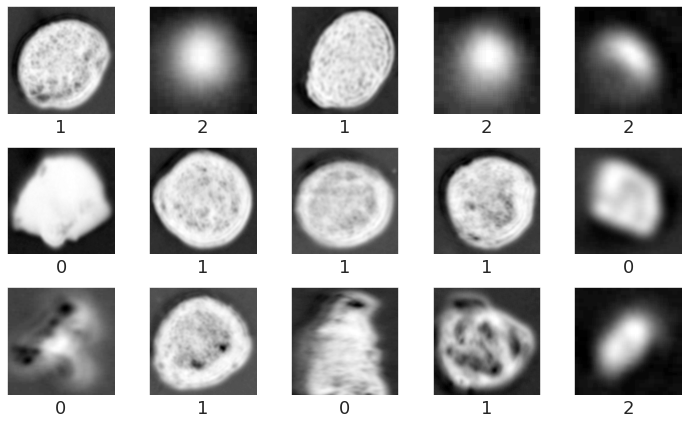

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(10,6))
for i in range(5):

    # train
    ax[0,i].imshow(train_images[i].reshape(img_rows, img_cols), cmap=plt.cm.binary)
    ax[0,i].set_xlabel(np.argmax(train_labels[i]), fontsize=18)
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([]); ax[0,i].grid(False)
    # val
    ax[1,i].imshow(val_images[i].reshape(img_rows, img_cols), cmap=plt.cm.binary)
    ax[1,i].set_xlabel(np.argmax(val_labels[i]), fontsize=18)
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([]); ax[1,i].grid(False)
    # test
    ax[2,i].imshow(test_images[i].reshape(img_rows, img_cols), cmap=plt.cm.binary)
    ax[2,i].set_xlabel(np.argmax(test_labels[i]), fontsize=18)
    ax[2,i].set_xticks([]); ax[2,i].set_yticks([]); ax[2,i].grid(False)
    
plt.tight_layout()
plt.show()

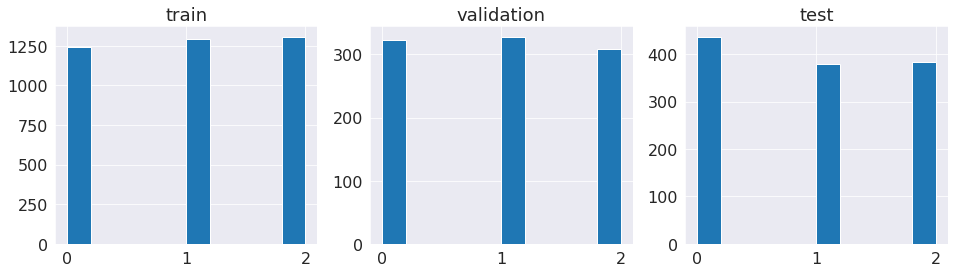

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
ax[0].hist(np.argmax(train_labels, axis=1).flatten()); ax[0].set_title('train', fontsize=18); ax[0].set_xticks(np.arange(num_classes)); ax[0].tick_params(axis='both', which='major', labelsize=16);
ax[1].hist(np.argmax(val_labels, axis=1).flatten()); ax[1].set_title('validation', fontsize=18); ax[1].set_xticks(np.arange(num_classes)); ax[1].tick_params(axis='both', which='major', labelsize=16);
ax[2].hist(np.argmax(test_labels, axis=1).flatten()); ax[2].set_title('test', fontsize=18); ax[2].set_xticks(np.arange(num_classes)); ax[2].tick_params(axis='both', which='major', labelsize=16);
plt.show()

### Create the CNN

In [16]:
input_img = Input(shape = (img_rows, img_cols, 1))
input_meta = Input(shape = (39,))
print(input_img.shape, input_meta.shape)
# This layer creates a convolution kernel that is convolved with the layer input 
# to produce a tensor of outputs.
# When using this l
# Layer as the first layer in a model, provide the keyword argument
# input_shape
# Same in padding means zero padding evenly to left/right and up/down 

x = Conv2D(filters=58,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu')(input_img)
x = MaxPooling2D(pool_size=2, strides=None)(x)
x = Conv2D(filters=154,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu')(x)
x = MaxPooling2D(pool_size=2, strides=None)(x)

x = Dropout(rate=0.3382)(x)
x = Flatten()(x)

x = Dense(units=177, activation='relu')(x) 
x1 = Dense(220,activation = 'relu')(input_meta) #New
x = concatenate([x,x1])
x = Dense(1263,activation = 'relu')(x)

output = Dense(units=num_classes, activation='softmax')(x)

model = Model(inputs = [input_img, input_meta], outputs = output)
model.summary()

(None, 256, 256, 1) (None, 39)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 58) 580         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 58) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 154 80542       max_pooling2d[0][0]              
_______________________________________________________________

In [17]:
# specify optimization strategy and metric used for monitoring during training
model.compile(loss=categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['categorical_accuracy'])

# the history object will contain a record of loss and metric values during training
history = model.fit([train_images, meta_train_images], train_labels,
                    batch_size=64,
                    epochs=15,
                    verbose=1,
                    validation_data=([val_images, meta_val_images], val_labels))

Epoch 1/15
60/60 [==============================] - 52s 294ms/step - loss: 0.5158 - categorical_accuracy: 0.8125 - val_loss: 0.3791 - val_categorical_accuracy: 0.8854
Epoch 2/15
60/60 [==============================] - 17s 288ms/step - loss: 0.3239 - categorical_accuracy: 0.8885 - val_loss: 0.3040 - val_categorical_accuracy: 0.9010
Epoch 3/15
60/60 [==============================] - 18s 294ms/step - loss: 0.2679 - categorical_accuracy: 0.9094 - val_loss: 0.2627 - val_categorical_accuracy: 0.9104
Epoch 4/15
60/60 [==============================] - 18s 293ms/step - loss: 0.2282 - categorical_accuracy: 0.9247 - val_loss: 0.2488 - val_categorical_accuracy: 0.9104
Epoch 5/15
60/60 [==============================] - 17s 289ms/step - loss: 0.1989 - categorical_accuracy: 0.9331 - val_loss: 0.2185 - val_categorical_accuracy: 0.9323
Epoch 6/15
60/60 [==============================] - 17s 289ms/step - loss: 0.1769 - categorical_accuracy: 0.9417 - val_loss: 0.2009 - val_categorical_accuracy: 0.942

### Evaluate training process

30/30 - 2s - loss: 0.1640 - categorical_accuracy: 0.9552


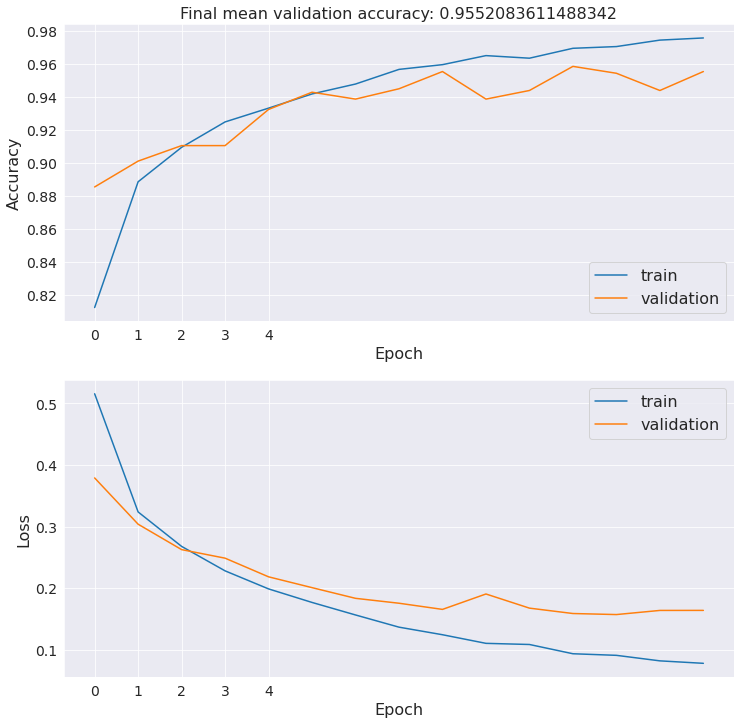

In [18]:
# evaluating model using all data (not in batches)
val_loss, val_acc = model.evaluate([val_images, meta_val_images], val_labels, verbose=2)

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=(12,12))
fs_L, fs_M, fs_S = 18, 16, 14
ax[0].plot(history.history['categorical_accuracy'], label='train')
ax[0].plot(history.history['val_categorical_accuracy'], label='validation')
ax[0].set_xlabel('Epoch', fontsize=fs_M)
ax[0].set_ylabel('Accuracy', fontsize=fs_M)
ax[0].tick_params(axis='both', which='major', labelsize=fs_S)
ax[0].set_title('Final mean validation accuracy: {}'.format(val_acc), fontsize=fs_M)
ax[0].set_xticks(range(0,5))
ax[0].legend(loc='lower right', fontsize=fs_M)

ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='validation')
ax[1].set_xlabel('Epoch', fontsize=fs_M)
ax[1].set_ylabel('Loss', fontsize=fs_M)
ax[1].tick_params(axis='both', which='major', labelsize=fs_S)
ax[1].set_xticks(range(0,5))
ax[1].legend(loc='upper right', fontsize=fs_M)

plt.show()

In [19]:
!pip install umap-learn

In [20]:
extractor_BeforeMeta = tensorflow.keras.Model(inputs=model.inputs,
                        outputs=model.layers[7].output)

extractor_AfterMeta = tensorflow.keras.Model(inputs=model.inputs,
                        outputs=model.layers[10].output)

extractor_End = tensorflow.keras.Model(inputs=model.inputs,
                        outputs=model.layers[-2].output)

In [21]:
l = 100

features_BM = extractor_BeforeMeta([train_images[0:l], meta_train_images[0:l]])
features_AM = extractor_BeforeMeta([train_images[0:l], meta_train_images[0:l]])
features_End = extractor_BeforeMeta([train_images[0:l], meta_train_images[0:l]])

In [22]:
import umap.umap_ as umap

reducer = umap.UMAP()

reducer.fit(features_BM)
umap_transformed_BM = reducer.transform(features_BM)

reducer.fit(features_AM)
umap_transformed_AM = reducer.transform(features_AM)

reducer.fit(features_End)
umap_transformed_End = reducer.transform(features_End)

In [23]:
f0_BM = umap_transformed_BM[np.argmax(train_labels[0:l],1) == 0]
f1_BM = umap_transformed_BM[np.argmax(train_labels[0:l],1) == 1]
f2_BM = umap_transformed_BM[np.argmax(train_labels[0:l],1) == 2]

f0_AM = umap_transformed_AM[np.argmax(train_labels[0:l],1) == 0]
f1_AM = umap_transformed_AM[np.argmax(train_labels[0:l],1) == 1]
f2_AM = umap_transformed_AM[np.argmax(train_labels[0:l],1) == 2]

f0_End = umap_transformed_End[np.argmax(train_labels[0:l],1) == 0]
f1_End = umap_transformed_End[np.argmax(train_labels[0:l],1) == 1]
f2_End = umap_transformed_End[np.argmax(train_labels[0:l],1) == 2]

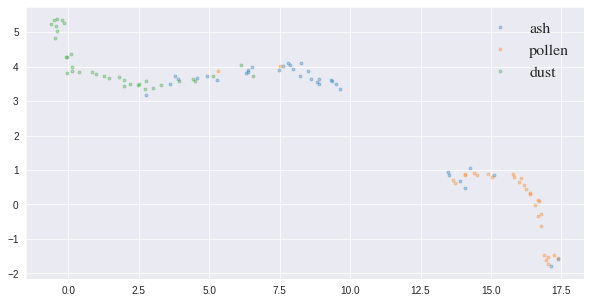

In [24]:
fig1, ax1 = plt.subplots(figsize=(10, 5))
reset_plt(16, 16)
trans=0.3
ax1.plot(f0_BM[:,0], f0_BM[:,1], '.', label = path[0], alpha=trans)
ax1.plot(f1_BM[:,0], f1_BM[:,1], '.', label = path[1], alpha=trans)
ax1.plot(f2_BM[:,0], f2_BM[:,1], '.', label = path[2], alpha=trans)

ax1.legend()

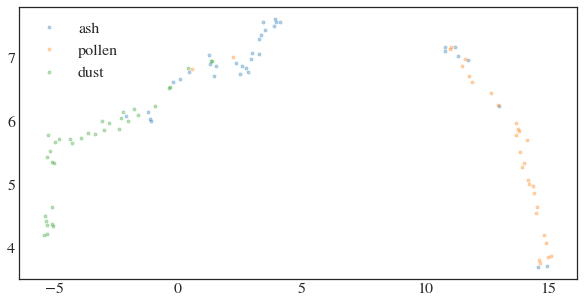

In [25]:
fig2, ax2 = plt.subplots(figsize=(10, 5))
reset_plt(16, 16)
trans=0.3
ax2.plot(f0_AM[:,0], f0_AM[:,1], '.', label = path[0], alpha=trans)
ax2.plot(f1_AM[:,0], f1_AM[:,1], '.', label = path[1], alpha=trans)
ax2.plot(f2_AM[:,0], f2_AM[:,1], '.', label = path[2], alpha=trans)

ax2.legend()

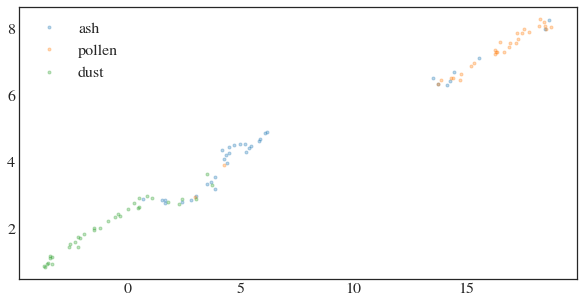

In [26]:
fig3, ax3 = plt.subplots(figsize=(10, 5))
reset_plt(16, 16)
trans=0.3
ax3.plot(f0_End[:,0], f0_End[:,1], '.', label = path[0], alpha=trans)
ax3.plot(f1_End[:,0], f1_End[:,1], '.', label = path[1], alpha=trans)
ax3.plot(f2_End[:,0], f2_End[:,1], '.', label = path[2], alpha=trans)

ax3.legend()

In [25]:
ypred_test = model.predict([test_images, meta_test_images])
ypred_train = model.predict([train_images, meta_train_images])

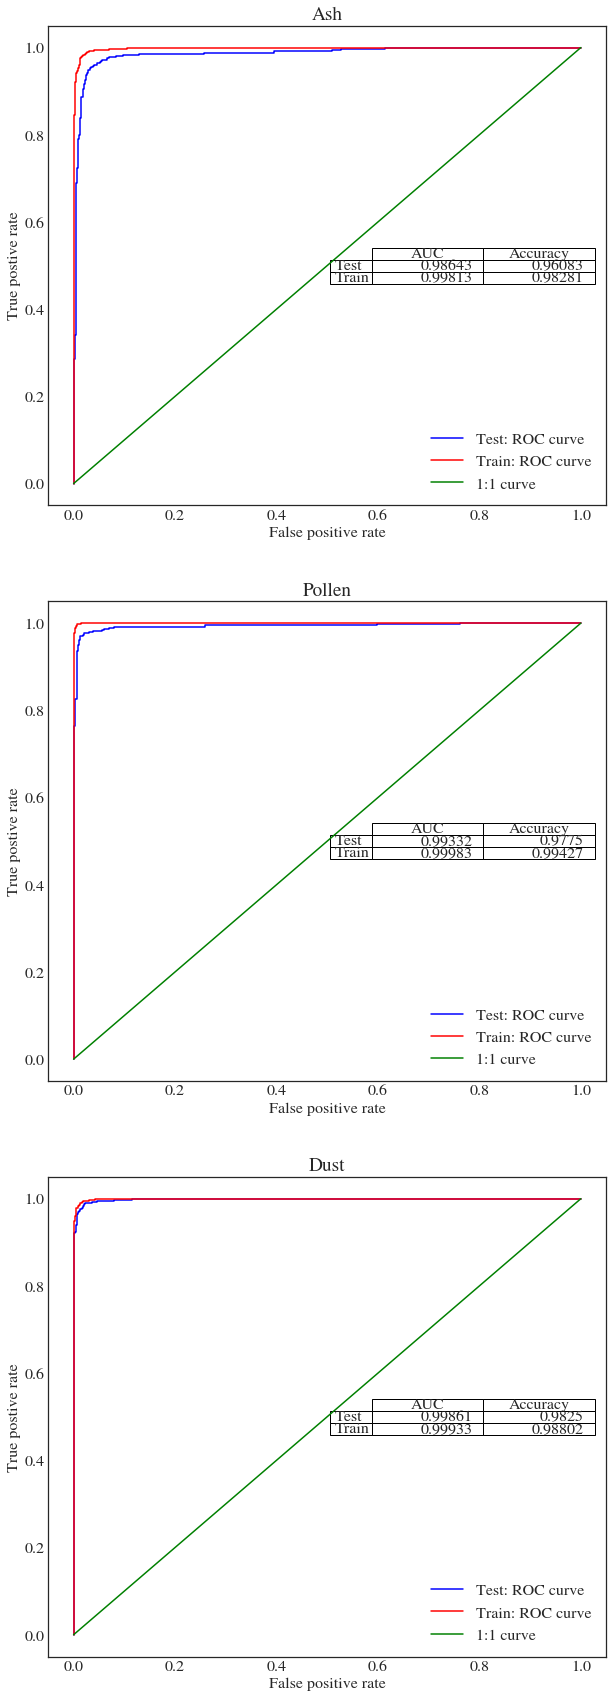

In [26]:
# Plotting the ROC curve, to test for overtaining and preformance
title = ['Ash', 'Pollen', 'Dust']
fig1, ax1 = plt.subplots(figsize=(10, 30), nrows=3)

for i in range(num_classes):
    fpr,tpr, threshold =sklearn.metrics.roc_curve(test_labels[:,i],ypred_test[:,i])
    ax1[i].plot(fpr,tpr,'b', label='Test: ROC curve')

    fpr_train, tpr_train, threshold_train =sklearn.metrics.roc_curve(train_labels[:,i], ypred_train[:,i])
    ax1[i].plot(fpr_train, tpr_train, 'r', label='Train: ROC curve')
    ax1[i].plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), 'g', label='1:1 curve')
    ax1[i].set(xlabel='False positive rate', ylabel='True postive rate', title=title[i])
    ax1[i].legend()


    # The AUC and accuracy is computed and printed in the figure
    auc_score_train = auc(fpr_train, tpr_train)   
    auc_score_test = auc(fpr, tpr)   

    acc_score_train = accuracy_score(train_labels[:,i],np.where(ypred_train[:,i] > 0.5, 1, 0))
    acc_score_test = accuracy_score(test_labels[:,i],np.where(ypred_test[:,i] > 0.5, 1, 0))

    row_labels=['Test',
            'Train']
    table_vals=[[round(auc_score_test,5), round(acc_score_test,5)],
            [round(auc_score_train,5), round(acc_score_train,5)]]
    col_labels=['AUC','Accuracy']
    the_table = ax1[i].table(cellText=table_vals,
                  colWidths = [0.2]*3,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center right')

### Inference

In [27]:
conf_matrix = tf.math.confusion_matrix(labels=np.argmax(test_labels, axis=1),
                                       predictions=np.argmax(ypred_test, axis = 1),
                                       num_classes=num_classes)
print('Confusion Matrix: ', conf_matrix)

# Original code:
#sess = tf.compat.v1.InteractiveSession()
#conf_matrix = confusion.eval(session=sess)     # Needs update to new TF...
#sess.close()

# Accuracy score for inference
error_rate = (np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))) / np.sum(np.diag(conf_matrix))
inf_acc = 1-error_rate
print(error_rate)
print(inf_acc)

Confusion Matrix:  tf.Tensor(
[[410  18   9]
 [  9 371   0]
 [ 11   0 372]], shape=(3, 3), dtype=int32)
0.040763226366001735
0.9592367736339983


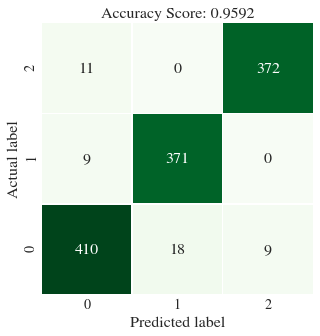

Correct: 1153/1200
Wrong: 47/1200


In [28]:
plt.figure(figsize=(10,5))
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, square=True, cbar=False, cmap='Greens')
ax.invert_yaxis()
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.title('Accuracy Score: {:.4f}'.format(inf_acc), fontsize=16)
plt.show()

print('Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix)),np.sum(conf_matrix)))
print('Wrong: {0}/{1}'.format((np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))),np.sum(conf_matrix)))

### Inspection of predictions

##### Correctly predicted images

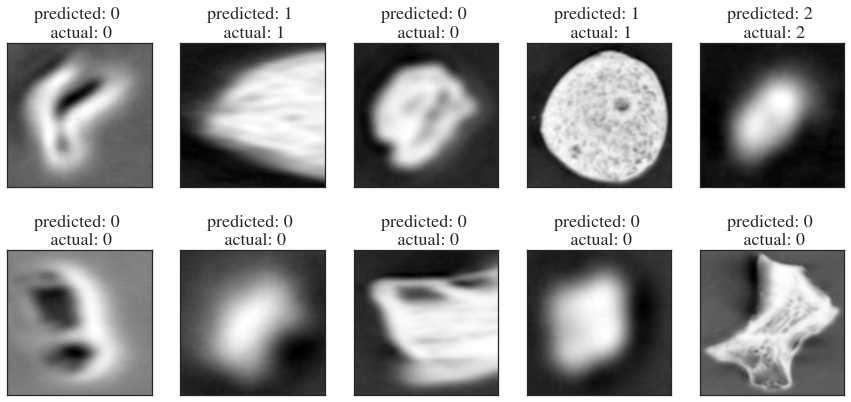

In [29]:
# show first 10 images that were correctly predicted
correct_idx = np.where(np.argmax(ypred_test, axis = 1) == np.argmax(test_labels, axis=1))[0]

fig, axs = plt.subplots(2,5, figsize=(15, 7))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(test_images[correct_idx[i],:,:,0], cmap=plt.cm.binary)
    axs[i].set_title('predicted: {} \n actual: {}'.format(np.argmax(ypred_test, axis = 1)[correct_idx[i]], np.argmax(test_labels, axis=1)[correct_idx[i]]), fontsize=18)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

##### Wrongly predicted images

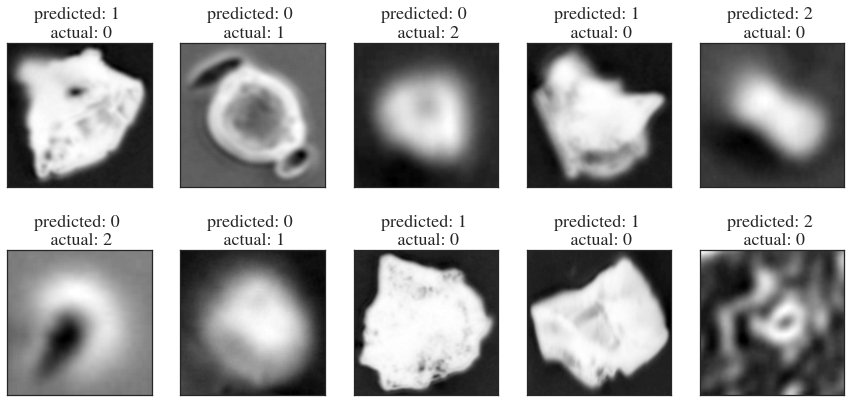

In [30]:
# Show first 10 images that were wrongly predicted:
wrong_idx = np.where(np.argmax(ypred_test, axis = 1) != np.argmax(test_labels, axis=1))[0]

fig, axs = plt.subplots(2,5, figsize=(15, 7))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(test_images[wrong_idx[i],:,:,0], cmap=plt.cm.binary)
    axs[i].set_title('predicted: {} \n actual: {}'.format(np.argmax(ypred_test, axis = 1)[wrong_idx[i]], np.argmax(test_labels, axis=1)[wrong_idx[i]]), fontsize=18)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

### Predict real data 

In [31]:
model.save('drive/MyDrive/my_model_v2')

### Baysian optimization

In [32]:
# Setting the model for baysian optimization

def create_model(filter_1=32, filter_2=64, drop_out = 0.40, nn1=128, nn2=200, nn3=1000, lr=0.001 ):
  input_img = Input(shape = (img_rows, img_cols, 1))
  input_meta = Input(shape = (39,))
  x = Conv2D(filters=filter_1,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu')(input_img)

  x = MaxPooling2D(pool_size=2, strides=None)(x)

  x = Conv2D(filters=filter_2,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu')(x)
  x = MaxPooling2D(pool_size=2, strides=None)(x)

  x = Dropout(rate=drop_out)(x)

  x = Flatten()(x)

  x = Dense(units=nn1, activation='relu')(x)
  x1 = Dense(units=nn2, activation='relu')(input_meta)
  x = concatenate([x,x1])
  x = Dense(units=nn3, activation='relu')(x)
  output = Dense(units=num_classes, activation='softmax')(x)

  model = Model(inputs = [input_img, input_meta], outputs = output)

  model.compile(loss=categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=['categorical_accuracy'])    
  return model

# Setting up the optimization network used by the baysian optimization
def optimize_network(data, meta_data, targets, data_val, meta_data_val, targets_val,\
                    filter_1, filter_2, drop_out, nn1, nn2, nn3, lr):
    
    #Create the model using the specified hyperparameters.
    model = create_model(filter_1, filter_2, drop_out, nn1, nn2, nn3, lr)
    
    # Train the model with the train dataset.
    model.fit([data,meta_data], targets, validation_data=([data_val, meta_data_val], targets_val),
                    batch_size=64,
                    epochs=10)

    # Evaluate the model 
    score = model.evaluate([data_val, meta_data_val], targets_val)
    print('Test loss:', score[0])
    print('Test categorical accuracy:', score[1])

    # Return the accuracy.

    return -1*score[0]

In [ ]:
from bayes_opt import BayesianOptimization
# Set up the model, with the traning and validation data 
eval_network = lambda filter_1, filter_2, drop_out, nn1, nn2, nn3, lr: optimize_network(train_images,\
                    meta_train_images, train_labels, val_images, meta_val_images, val_labels,
                    int(filter_1), int(filter_2), drop_out, int(nn1), int(nn2), int(nn3), lr) 

# Bounded region of parameter space
pbounds = {'filter_1': (30,100), 'filter_2':(100, 200),
           'drop_out':(0.2,0.6), 'nn1': (128, 200), 'nn2': (200,300), 'nn3':(1000, 1300), 'lr':(1e-6,1e-3) }


# Setup the baysian optimization
optimizer = BayesianOptimization(
    f=eval_network,
    pbounds=pbounds,
    verbose=1,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

# Preform the baysian optimization
#start_time = time.time()
optimizer.maximize(init_points=5, n_iter=15,)
#time_took = time.time() - start_time

#print(f"Total runtime: {time_took}")
print(optimizer.max)

|   iter    |  target   | drop_out  | filter_1  | filter_2  |    lr     |    nn1    |    nn2    |    nn3    |
-------------------------------------------------------------------------------------------------------------
Epoch 1/10
60/60 [==============================] - 23s 321ms/step - loss: 0.4387 - categorical_accuracy: 0.8378 - val_loss: 0.1926 - val_categorical_accuracy: 0.9354
Epoch 2/10
60/60 [==============================] - 17s 286ms/step - loss: 0.1344 - categorical_accuracy: 0.9521 - val_loss: 0.1453 - val_categorical_accuracy: 0.9458
Epoch 3/10
60/60 [==============================] - 17s 279ms/step - loss: 0.0946 - categorical_accuracy: 0.9648 - val_loss: 0.1651 - val_categorical_accuracy: 0.9500
Epoch 4/10
60/60 [==============================] - 17s 277ms/step - loss: 0.0682 - categorical_accuracy: 0.9784 - val_loss: 0.1764 - val_categorical_accuracy: 0.9479
Epoch 5/10
60/60 [==============================] - 17s 278ms/step - loss: 0.0505 - categorical_accuracy: 0.9828

In [ ]:
# Setting up the found optimal parameters
params_BO = optimizer.max['params']
params_BO['nn1'] = int(params_BO['nn1'])
params_BO['nn2'] = int(params_BO['nn2'])
params_BO['nn3'] = int(params_BO['nn3'])
params_BO['filter_1'] = int(params_BO['filter_1'])
params_BO['filter_2'] = int(params_BO['filter_2'])
print(params_BO)


In [ ]:
# create the neural network using the found optimal hyper parameters
model_BO = create_model(**params_BO)

start=datetime.now()
# Train the model using the traning and valdiation data set
history_BO = model_BO.fit([train_images, meta_train_images], train_labels,
                    batch_size=62,
                    epochs=60,
                    verbose=1,
                    validation_data=([val_images, meta_val_images], val_labels))
stop=datetime.now()
execution_time_NN = stop-start
print(execution_time_NN)

In [ ]:
# evaluating model using all data (not in batches)
val_loss, val_acc = model_BO.evaluate([val_images, meta_val_images], val_labels, verbose=2)

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(12,12))
fs_L, fs_M, fs_S = 18, 16, 14
ax[0].plot(history_BO.history['categorical_accuracy'], label='train')
ax[0].plot(history_BO.history['val_categorical_accuracy'], label='validation')
ax[0].set_xlabel('Epoch', fontsize=fs_M)
ax[0].set_ylabel('Accuracy', fontsize=fs_M)
ax[0].tick_params(axis='both', which='major', labelsize=fs_S)
ax[0].set_title('Final mean validation accuracy: {}'.format(val_acc), fontsize=fs_M)
ax[0].set_xticks(range(0,5))
ax[0].legend(loc='lower right', fontsize=fs_M)

ax[1].plot(history_BO.history['loss'], label='train')
ax[1].plot(history_BO.history['val_loss'], label='validation')
ax[1].set_xlabel('Epoch', fontsize=fs_M)
ax[1].set_ylabel('Loss', fontsize=fs_M)
ax[1].tick_params(axis='both', which='major', labelsize=fs_S)
ax[1].set_xticks(range(0,5))
ax[1].legend(loc='upper right', fontsize=fs_M)

plt.show()

In [ ]:
ypred_test = model_BO.predict([test_images, meta_test_images])
ypred_train = model_BO.predict([train_images, meta_train_images])
# Plotting the ROC curve, to test for overtaining and preformance
title = ['Ash','Pollen','Dust']
fig1, ax1 = plt.subplots(figsize=(10, 30), nrows=3)

for i in range(num_classes):
    fpr,tpr, threshold =sklearn.metrics.roc_curve(test_labels[:,i], ypred_test[:,i])
    ax1[i].plot(fpr, tpr,'b', label='Test: ROC curve')

    fpr_train,tpr_train, threshold_train =sklearn.metrics.roc_curve(train_labels[:,i], ypred_train[:,i])
    ax1[i].plot(fpr_train,tpr_train,'r', label='Train: ROC curve')
    ax1[i].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100), 'g', label='1:1 curve')
    ax1[i].set(xlabel='False positive rate', ylabel='True postive rate', title=title[i])
    ax1[i].legend()


    # The AUC and accuracy is computed and printed in the figure
    auc_score_train = auc(fpr_train, tpr_train)   
    auc_score_test = auc(fpr, tpr)   

    acc_score_train = accuracy_score(train_labels[:,i], np.where(ypred_train[:,i] > 0.5, 1, 0))
    acc_score_test = accuracy_score(test_labels[:,i], np.where(ypred_test[:,i] > 0.5, 1, 0))

    row_labels=['Test',
            'Train']
    table_vals=[[round(auc_score_test,5), round(acc_score_test,5)],
            [round(auc_score_train,5), round(acc_score_train,5)]]
    col_labels=['AUC','Accuracy']
    the_table = ax1[i].table(cellText=table_vals,
                  colWidths = [0.2]*3,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center right')

In [ ]:
conf_matrix = tf.math.confusion_matrix(labels=np.argmax(test_labels, axis=1),
                                       predictions=np.argmax(ypred_test, axis = 1),
                                       num_classes=num_classes)
print('Confusion Matrix: ', conf_matrix)

# Original code:
#sess = tf.compat.v1.InteractiveSession()
#conf_matrix = confusion.eval(session=sess)     # Needs update to new TF...
#sess.close()f

# Accuracy score for inference
error_rate = (np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))) / np.sum(np.diag(conf_matrix))
inf_acc = 1-error_rate
plt.figure(figsize=(10,5))
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, square=True, cbar=False, cmap='Greens')
ax.invert_yaxis()
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.title('Accuracy Score: {:.4f}'.format(inf_acc), fontsize=16)
plt.show()

print('Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix)), np.sum(conf_matrix)))
print('Wrong: {0}/{1}'.format((np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))), np.sum(conf_matrix)))